Saving Data_Breach_Chronology_Kaplameyer.xlsx to Data_Breach_Chronology_Kaplameyer (5).xlsx
📂 Dimensões do dataset (linhas, colunas): (72553, 3)

📌 Tipos de dados por coluna:
breach_date          object
organization_type    object
breach_type          object
dtype: object

🔎 Primeiras 5 linhas do dataset:
  breach_date organization_type breach_type
0  2020-09-05               BSR        HACK
1  2021-08-16              UNKN        UNKN
2  2021-03-15              UNKN        UNKN
3  2010-02-18               BSO        PORT
4  2020-09-10               MED        UNKN

❗ Valores ausentes por coluna:
breach_date          0
organization_type    0
breach_type          0
dtype: int64

📊 Estatísticas descritivas para colunas numéricas:
       breach_date organization_type breach_type
count        72553             72553       72553
unique        4716                 8           8
top           UNKN              UNKN        UNKN
freq         32411             22540       40038

📊 Contagem de reg

/tmp/ipython-input-911260926.py:102: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  serie = df.resample('M').size().fillna(0)


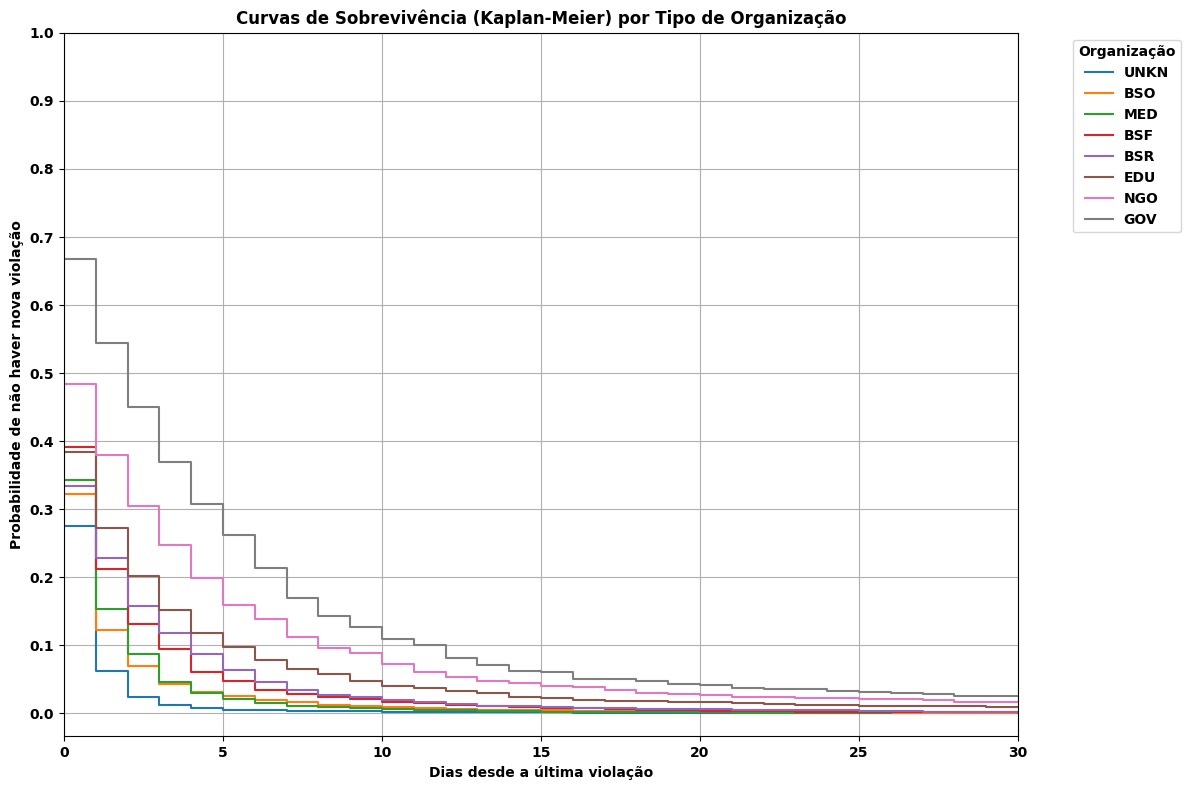

In [56]:
# ============================================
# 1. Importação de Bibliotecas
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ============================================
# 2. Upload e Carga do Dataset
# ============================================

# Faz upload do arquivo local para o Colab
uploaded = files.upload()

# Lê o arquivo Excel enviado
df_original = pd.read_excel(next(iter(uploaded)))

# Faz uma cópia do DataFrame original para evitar alterar os dados brutos
df = df_original.copy()

# ============================================
# 3. Visão Geral do Dataset
# ============================================

print("📂 Dimensões do dataset (linhas, colunas):", df.shape)
print("\n📌 Tipos de dados por coluna:")
print(df.dtypes)

print("\n🔎 Primeiras 5 linhas do dataset:")
print(df.head())

# Verifica valores ausentes
print("\n❗ Valores ausentes por coluna:")
print(df.isnull().sum())

# Estatísticas descritivas das colunas numéricas
print("\n📊 Estatísticas descritivas para colunas numéricas:")
print(df.describe())

# Contagem por tipo de organização
if 'organization_type' in df.columns:
    print("\n📊 Contagem de registros por tipo de organização:")
    print(df['organization_type'].value_counts())

# Contagem por tipo de violação
if 'breach_type' in df.columns:
    print("\n📊 Contagem de registros por tipo de violação:")
    print(df['breach_type'].value_counts())

# Salva as contagens em CSV
df['organization_type'].value_counts().to_csv("contagem_por_organization_type.csv")
df['breach_type'].value_counts().to_csv("contagem_por_breach_type.csv")

print("\n✅ Arquivos de contagem salvos:")
print("- contagem_por_organization_type.csv")
print("- contagem_por_breach_type.csv")

# ============================================
# 4. Pré-processamento de Datas
# ============================================

# Função para ajustar datas incompletas (ano ou ano-mês)
def ajustar_datas(data_str):
    """
    Converte valores de datas que podem estar incompletos:
      - 'YYYY' → 'YYYY-01-01'
      - 'YYYY-MM' → 'YYYY-MM-01'
      - 'YYYY-MM-DD' → mantém
      - Valores inválidos → NaT
    """
    try:
        if pd.isna(data_str):
            return pd.NaT
        data_str = str(data_str)
        if len(data_str) == 4:            # Apenas ano
            return pd.Timestamp(data_str + '-01-01')
        elif len(data_str) == 7:          # Ano e mês
            return pd.Timestamp(data_str + '-01')
        else:                             # Data completa
            return pd.Timestamp(data_str)
    except:
        return pd.NaT

# Aplica a função na coluna de datas
df['breach_date'] = df['breach_date'].apply(ajustar_datas)

# Converte a coluna para datetime de forma robusta
df['breach_date'] = pd.to_datetime(df['breach_date'], errors='coerce')

# Define a coluna de data como índice do DataFrame
df.set_index('breach_date', inplace=True)

# Filtra o período de interesse (2010 a 2023)
df = df[(df.index >= '2010-01-01') & (df.index < '2024-01-01')]

# ============================================
# 5. Série Temporal Mensal
# ============================================

# Conta incidentes por mês
serie = df.resample('M').size().fillna(0)

# ============================================
# 6. Instalação e Importação da Biblioteca de Sobrevivência
# ============================================
!pip install lifelines --quiet
from lifelines import KaplanMeierFitter

# ============================================
# 7. Kaplan-Meier: Curvas de Sobrevivência
# ============================================

# Contagem de incidentes por tipo de organização
incident_counts = df['organization_type'].value_counts()

# Mantém apenas organizações com pelo menos 10 incidentes
orgs_to_keep = incident_counts[incident_counts >= 10].index.tolist()

# Configurações do gráfico
plt.figure(figsize=(12, 8))
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

# Loop para calcular Kaplan-Meier para cada organização
for org in orgs_to_keep:
    # Filtra os dados da organização e ordena por data
    df_org = df[df['organization_type'] == org].sort_index()

    # Calcula dias desde a última violação
    df_org['days_since_last'] = df_org.index.to_series().diff().dt.days

    # Remove a primeira linha (não tem valor para diff) e registros nulos
    df_org = df_org.dropna(subset=['days_since_last'])

    # Continua apenas se houver pelo menos 2 incidentes
    if len(df_org) < 2:
        continue

    # Tempo até o novo evento
    T = df_org['days_since_last']

    # Vetor de eventos (1 indica que o evento ocorreu)
    E = [1] * len(df_org)

    # Ajusta o modelo Kaplan-Meier
    kmf = KaplanMeierFitter()
    kmf.fit(T, event_observed=E, label=org)

    # Plota a curva da organização
    kmf.plot(ci_show=False)

# ============================================
# 8. Ajustes Finais do Gráfico
# ============================================

plt.xlim(0, 30)                     # Limite do eixo X (dias)
plt.xticks(range(0, 31, 5))         # Marcas no eixo X a cada 5 dias
plt.yticks([i / 10 for i in range(0, 11, 1)])  # Marcas no eixo Y de 0 a 1

plt.xlabel('Dias desde a última violação')
plt.ylabel('Probabilidade de não haver nova violação')
plt.title('Curvas de Sobrevivência (Kaplan-Meier) por Tipo de Organização')
plt.legend(title='Organização', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
